In [1]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

import wandb
from wandb.keras import WandbCallback

import os

2021-10-18 20:52:49.160471: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '0' # 초기화 할 GPU Number
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
sess = tf.compat.v1.Session(config=config)

2021-10-18 20:52:50.210196: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-18 20:52:50.211432: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-18 20:52:50.248883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 20:52:50.249503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce GTX 1660 SUPER computeCapability: 7.5
coreClock: 1.86GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidt

In [3]:
img_rows , img_cols = 224, 224 # MobileNet input size

# imagenet pretrained된 가중치 가져옴
MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

2021-10-18 20:52:50.631342: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-18 20:52:50.631511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 20:52:50.632343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce GTX 1660 SUPER computeCapability: 7.5
coreClock: 1.86GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 312.97GiB/s
2021-10-18 20:52:50.632380: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-18 20:52:50.632404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-18 20:52:50.632415: I tensorflow/stream_executor/pla

In [4]:
for layer in MobileNet.layers:
    layer.trainable = True
    
for (i, layer) in enumerate(MobileNet.layers):
    print(str(i), layer.__class__.__name__, layer.trainable)

0 InputLayer True
1 Conv2D True
2 BatchNormalization True
3 ReLU True
4 DepthwiseConv2D True
5 BatchNormalization True
6 ReLU True
7 Conv2D True
8 BatchNormalization True
9 ReLU True
10 ZeroPadding2D True
11 DepthwiseConv2D True
12 BatchNormalization True
13 ReLU True
14 Conv2D True
15 BatchNormalization True
16 ReLU True
17 DepthwiseConv2D True
18 BatchNormalization True
19 ReLU True
20 Conv2D True
21 BatchNormalization True
22 ReLU True
23 ZeroPadding2D True
24 DepthwiseConv2D True
25 BatchNormalization True
26 ReLU True
27 Conv2D True
28 BatchNormalization True
29 ReLU True
30 DepthwiseConv2D True
31 BatchNormalization True
32 ReLU True
33 Conv2D True
34 BatchNormalization True
35 ReLU True
36 ZeroPadding2D True
37 DepthwiseConv2D True
38 BatchNormalization True
39 ReLU True
40 Conv2D True
41 BatchNormalization True
42 ReLU True
43 DepthwiseConv2D True
44 BatchNormalization True
45 ReLU True
46 Conv2D True
47 BatchNormalization True
48 ReLU True
49 DepthwiseConv2D True
50 BatchNorma

In [5]:
def addTopModelMobileNet(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    
    return top_model
    

In [6]:
train_data_dir = 'paper_dataset/train'
validation_data_dir = 'paper_dataset/validation'
test_data_dir = 'paper_dataset/test'

train_datagen = ImageDataGenerator(
                    rescale=1./255,
#                     rotation_range=30,
#                     width_shift_range=0.3,
#                     height_shift_range=0.3,
#                     fill_mode='nearest'
                    )

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size=(img_rows, img_cols),
batch_size=batch_size,
class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
validation_data_dir,
target_size=(img_rows, img_cols),
batch_size=batch_size,
class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2446 images belonging to 2 classes.
Found 613 images belonging to 2 classes.
Found 833 images belonging to 2 classes.


In [7]:
num_classes = train_generator.num_classes
FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs=MobileNet.input, outputs=FC_Head)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [8]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from datetime import datetime

In [9]:
wandb.init(project='KICS_FALL', entity='yhkim')
config = wandb.config

config.learning_rate = 0.01
config.momentum = 0.937
config.nesterov = True
config.epochs =100

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yhkim (use `wandb login --relogin` to force relogin)
/home/yongho/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
2021-10-18 20:52:52.599112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [10]:
checkpoint = ModelCheckpoint(
    'scene_clasification_MobileNet.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=5,
                                           verbose=1,
                                           factor=0.2,
                                           min_lr=0.0001)

# tensorboard = TensorBoard(log_dir=f'./logs/{datetime.now().strftime("%Y%m%d-%H%M%S")}')

callbacks = [checkpoint, earlystop, WandbCallback(data_type='image', labels=['not_pitching', 'pitching'])]

In [11]:
model.compile(loss='categorical_crossentropy',
             optimizer=SGD(lr=config.learning_rate, momentum=config.momentum,
                           nesterov=config.nesterov),
             metrics=['accuracy']
             )

nb_train_samples = len(train_generator.classes)
nb_validation_samples = len(validation_generator.classes)

epochs = config.epochs

In [12]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size,
                              epochs=config.epochs,
                              callbacks=callbacks,
                              )

/home/yongho/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-18 20:52:56.391951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-18 20:52:56.408394: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593330000 Hz


Epoch 1/100


2021-10-18 20:52:57.487140: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-18 20:52:57.774779: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


76/76 [==============================] - 29s 351ms/step - loss: 0.3034 - accuracy: 0.8565 - val_loss: 0.1058 - val_accuracy: 0.9720

Epoch 00001: val_loss improved from inf to 0.10576, saving model to scene_clasification_MobileNet.h5
Epoch 2/100
76/76 [==============================] - 26s 340ms/step - loss: 0.0535 - accuracy: 0.9832 - val_loss: 0.0494 - val_accuracy: 0.9852

Epoch 00002: val_loss improved from 0.10576 to 0.04944, saving model to scene_clasification_MobileNet.h5
Epoch 3/100
76/76 [==============================] - 26s 342ms/step - loss: 0.0283 - accuracy: 0.9909 - val_loss: 0.0577 - val_accuracy: 0.9819

Epoch 00003: val_loss did not improve from 0.04944
Epoch 4/100
76/76 [==============================] - 26s 343ms/step - loss: 0.0130 - accuracy: 0.9966 - val_loss: 0.1033 - val_accuracy: 0.9786

Epoch 00004: val_loss did not improve from 0.04944
Epoch 5/100
76/76 [==============================] - 26s 345ms/step - loss: 0.0111 - accuracy: 0.9972 - val_loss: 0.0793 - v

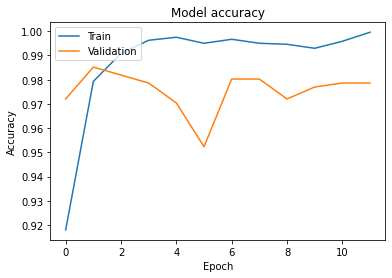

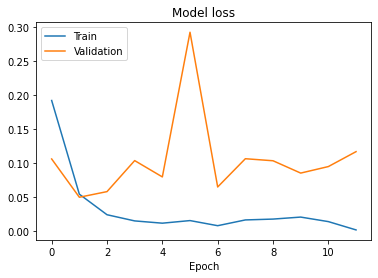

In [13]:
history = model.history

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
model.save('paper_data')

2021-10-18 20:58:30.431489: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: paper_data/assets


In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score
import sklearn

In [17]:
model = load_model('./paper_data')
classes = os.listdir('./paper_dataset/train')

In [18]:
img_rows, img_cols = 224, 224
batch_size = 64

test_data_dir = 'paper_dataset/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 833 images belonging to 2 classes.


In [19]:
test_generator.reset()
Y_pred = model.predict_generator(test_generator, verbose=1)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

/home/yongho/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


14/14 [==============================] - 4s 238ms/step


In [20]:
print(sum(y_pred==classes)/833)

0.9015606242496998


## Scene Classification

In [21]:
print('-- Confusion Matrix --')
print(confusion_matrix(test_generator.classes[test_generator.index_array], y_pred))

-- Confusion Matrix --
[[656   0]
 [ 82  95]]


In [22]:
class_names = ['not_pitching', 'pitching']

In [23]:
print(classification_report(test_generator.classes[test_generator.index_array], y_pred, target_names=class_names))

              precision    recall  f1-score   support

not_pitching       0.89      1.00      0.94       656
    pitching       1.00      0.54      0.70       177

    accuracy                           0.90       833
   macro avg       0.94      0.77      0.82       833
weighted avg       0.91      0.90      0.89       833



## Object Detection

In [24]:
od_true = np.zeros((833,), dtype=int)
od_predict = np.zeros((833,), dtype=int)

for x in os.listdir('paper_dataset/test/pitching'):
    od_true[int(x.replace('.','_').split('_')[1])] = 1

for x in os.listdir('od_result'):
    od_predict[int(x.replace('.','_').split('_')[1])] = 1

FileNotFoundError: [Errno 2] No such file or directory: 'od_result'

In [ ]:
print('-- Confusion Matrix --')
print(confusion_matrix(od_true, od_predict))

In [ ]:
print(classification_report(od_true, od_predict, target_names=class_names))

In [ ]:
accuracy_score(od_true, od_predict)

In [ ]:
scores = model.evaluate_generator(test_generator)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

In [ ]:
model.metrics_names

In [ ]:
# # random_img = random.sample(os.listdir('./paper_dataset/test/not_pitching/'), 1)[0]
# img = cv2.imread(f"./paper_dataset/test/pitching/frame_515.jpg")
# resize_img = cv2.resize(img.astype('float32') / 255, (224, 224))
# # print(random_img)

# output = model.predict(resize_img[np.newaxis])

# plt.title(f"True : not_pitching       Predict : {'not pitching' if np.argmax(output) == 0 else 'pitching'}")
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.savefig('Predict not_pitching scene', format='jpg')
# # cv2.imwrite('Predict pitching scene.jpg', img)
# # plt.imsave('Predict pitching scene.jpg', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
# outputs = model.predict_generator(test_generator, verbose=1)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# print(test_generator.class_indices)
# print(outputs)

In [ ]:
# result = []
# for x in output:
#     result.append(np.argmax(x))

In [ ]:
# not_pitching = [x for x in result if x == 0]
# pitching = [x for x in result if x == 1]

# print(len(not_pitching))
# print(len(pitching))

In [ ]:
# outputs[213]

In [ ]:
# import shutil
# from glob import glob
# from sklearn.model_selection import train_test_split

In [ ]:
# src = '../0310_dataset'
# dst = '../0310_dataset/train'

### Train 폴더에 데이터 전부 옮기기

In [ ]:
# dir_list = os.listdir(src)
# dir_list.remove('train')
# dir_list.remove('validation')
# print(dir_list)
# cnt = 0
# for x in dir_list:
#     for y in os.listdir(f'{src}/{x}'):
#         if y.endswith('.jpg'):
#             print(y)
#             shutil.move(f'{src}/{x}/{y}', f'{dst}/{str(cnt).zfill(5)}.jpg')
#             shutil.move(f'{src}/{x}/{y.replace(".jpg", ".txt")}', f'{dst}/{str(cnt).zfill(5)}.txt')
#             cnt += 1
# print(cnt)

In [ ]:
# data = os.listdir(f'{src}/train')
# img_list = []

# for x in data:
#     if x.endswith('.jpg'):
#         img_list.append(x)


# print(len(img_list))
# # print(img_list)

# train_img_list, val_img_list = train_test_split(img_list, test_size=0.2, random_state=42)

# print(len(train_img_list), len(val_img_list))

In [ ]:
# for x in val_img_list:
#     shutil.move(f'{src}/train/{x}', f'{src}/validation/{x}')